## 0. Setup

Run the next cell to import libraries. Do not add new external packages.


In [1]:
import random
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

# Reproducibility
random.seed(0)


## 1. Vacuum World Environment

The environment has:
- two locations: `Left`, `Right`
- each location is `Clean` or `Dirty`
- the agent occupies one location at a time

A **percept** is a tuple `(location, status_of_current_square)`.

Run the next cell to define the environment.


In [2]:
Location = str  # 'Left' or 'Right'
Status   = str    # 'Clean' or 'Dirty'
Action   = str    # 'Left', 'Right', 'Suck', 'NoOp'
Percept  = Tuple[Location, Status]

@dataclass
class VacuumWorld:
    dirt: Dict[Location, Status]
    agent_loc: Location
    step_count: int = 0
    max_steps: int = 20

    def percept(self) -> Percept:
        return (self.agent_loc, self.dirt[self.agent_loc])

    def step(self, action: Action) -> Tuple[Percept, float, bool]:
        self.step_count += 1

        if action == "Suck":
            self.dirt[self.agent_loc] = "Clean"
        elif action == "Left":
            self.agent_loc = "Left"
        elif action == "Right":
            self.agent_loc = "Right"
        elif action == "NoOp":
            pass
        else:
            raise ValueError("Unknown action")

        clean_count = sum(1 for s in self.dirt.values() if s == "Clean")
        move_cost = 0.1 if action in ("Left", "Right") else 0.0
        reward = float(clean_count) - move_cost

        done = self.step_count >= self.max_steps
        return self.percept(), reward, done


def random_world(p_dirty: float = 0.5, start_loc: Optional[Location] = None, max_steps: int = 20):
    dirt = {
        "Left": "Dirty" if random.random() < p_dirty else "Clean",
        "Right": "Dirty" if random.random() < p_dirty else "Clean",
    }
    if start_loc is None:
        start_loc = random.choice(["Left", "Right"])
    return VacuumWorld(dirt=dirt, agent_loc=start_loc, max_steps=max_steps)


## 2. TODO: Simple Reflex Agent (Condition–Action Rules)

Implement the classic simple reflex logic:

- If current square is `Dirty` → `Suck`
- Else move to the other square (`Left` ↔ `Right`)

**Important:** This agent ignores percept history. It reacts to the current percept only.


In [3]:
def simple_reflex_agent(percept: Percept) -> Action:
    loc, status = percept
    if status == "Dirty":
        return "Suck"
    return "Right" if loc == "Left" else "Left"


### Quick tests for your simple reflex agent

Run the next cell. All asserts should pass after you implement `simple_reflex_agent`.


In [4]:
# Unit tests (do not modify)
assert simple_reflex_agent(("Left", "Dirty")) == "Suck"
assert simple_reflex_agent(("Right", "Dirty")) == "Suck"
assert simple_reflex_agent(("Left", "Clean")) in ("Right",)   # move to other
assert simple_reflex_agent(("Right", "Clean")) in ("Left",)   # move to other
print("simple_reflex_agent tests passed")


simple_reflex_agent tests passed


## 3. TODO: Model-Based Reflex Agent (Internal State)

A model-based reflex agent maintains an **internal state** that summarizes what it knows.

We will store state as:

```python
state = { "dirty": { "Left": "?", "Right": "?" } }
```

Where:
- `"?"` means unknown
- the agent updates the entry for its current location based on the percept

Decision logic (suggested):
1. If current square is `Dirty` → `Suck`
2. Else, if the other square is not known to be `Clean` → move to it
3. Else → `NoOp`

**Important:** In this notebook we return `(action, state)` so state can persist across calls.


In [5]:
def mb_reflex_agent(percept: Percept, state: Optional[dict] = None):
    loc, status = percept

    if state is None:
        state = {"dirty": {"Left": "?", "Right": "?"}}

    state["dirty"][loc] = status

    if status == "Dirty":
        return "Suck", state

    other = "Right" if loc == "Left" else "Left"
    if state["dirty"][other] != "Clean":
        return other, state

    return "NoOp", state


### Quick tests for your model-based reflex agent

Run the next cell. All asserts should pass after you implement `mb_reflex_agent`.


In [6]:
# Unit tests (do not modify)
a, st = mb_reflex_agent(("Left", "Clean"), None)
assert "dirty" in st and "Left" in st["dirty"] and "Right" in st["dirty"]
assert st["dirty"]["Left"] == "Clean"

a, st2 = mb_reflex_agent(("Left", "Dirty"), st)
assert a == "Suck"
assert st2["dirty"]["Left"] == "Dirty"

print("mb_reflex_agent basic tests passed")


mb_reflex_agent basic tests passed


## 4. Episode Runner

We will run an agent in the environment for `max_steps` steps.

- Simple reflex agent returns only an action.
- Model-based agent returns `(action, state)`.


In [7]:
def run_episode(env: VacuumWorld, agent_type: str = "simple", verbose: bool = False) -> dict:
    total_reward = 0.0
    trajectory = []
    state = None

    while True:
        percept = env.percept()

        if agent_type == "simple":
            action = simple_reflex_agent(percept)
        elif agent_type == "model_based":
            action, state = mb_reflex_agent(percept, state)
        else:
            raise ValueError("agent_type must be 'simple' or 'model_based'")

        next_percept, reward, done = env.step(action)
        total_reward += reward

        trajectory.append({
            "t": env.step_count,
            "percept": percept,
            "action": action,
            "reward": reward,
            "dirt": dict(env.dirt),
            "loc": env.agent_loc,
            "state": None if state is None else {"dirty": dict(state["dirty"])},
        })

        if verbose:
            print(f"t={env.step_count:2d} percept={percept} action={action:5s} "
                  f"dirt={env.dirt} reward={reward:.2f} state={trajectory[-1]['state']}")

        if done:
            break

    return {"total_reward": total_reward, "trajectory": trajectory}


## 5. TODO: Experiment and Compare

Implement `evaluate()` to compare average total reward for both agents across many random episodes.

Requirements:
- Use the same initial environment for both agents per episode.
- Return a dictionary with keys `"simple"` and `"model_based"`, each mapped to a list of total rewards.


In [14]:
def evaluate(n_episodes: int = 200, p_dirty: float = 0.5, max_steps: int = 20, seed: int = 0):
    random.seed(seed)
    results = {"simple": [], "model_based": []}

    for _ in range(n_episodes):
        env1 = random_world(p_dirty=p_dirty, max_steps=max_steps)
        env2 = VacuumWorld(
            dirt=dict(env1.dirt),
            agent_loc=env1.agent_loc,
            max_steps=max_steps
        )

        results["simple"].append(run_episode(env1, "simple")["total_reward"])
        results["model_based"].append(run_episode(env2, "model_based")["total_reward"])

    return results


### Run your evaluation

After implementing `evaluate()`, run the next cell to see average performance.


In [15]:
results = evaluate(n_episodes=500, p_dirty=0.5, max_steps=20, seed=42)
avg_simple = sum(results["simple"]) / len(results["simple"])
avg_mb = sum(results["model_based"]) / len(results["model_based"])
avg_simple, avg_mb


(37.35419999999999, 39.154)

## 6. Plot the Results

Run the next cell to visualize distributions.


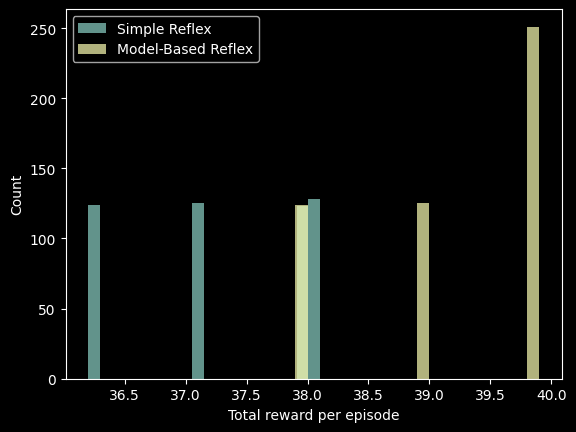

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(results["simple"], bins=20, alpha=0.7, label="Simple Reflex")
plt.hist(results["model_based"], bins=20, alpha=0.7, label="Model-Based Reflex")
plt.xlabel("Total reward per episode")
plt.ylabel("Count")
plt.legend()
plt.show()


## 7. Written Questions (Answer in Markdown)

### Q1. Scaling
Why does an explicit lookup table representation of the agent function become infeasible as environments grow?

**Answer:** *An explicit lookup table becomes infeasible because the number of possible percept histories grows exponentially as the environment becomes larger, making storage and computation impractical.*

### Q2. Partial Observability
Explain, in your own words, why partial observability motivates internal state.

**Answer:** *Partial observability motivates internal state because the agent cannot rely solely on current percepts and must remember or infer information about unobserved parts of the environment.*

### Q3. Model-Based vs Simple Reflex
In Vacuum World as implemented here, when (if ever) does internal state help? What changes to the environment would make internal state more important?

**Answer:** *Internal state helps once both squares are clean by preventing unnecessary movement. In larger or noisier environments, internal state becomes essential for good performance.*

### Q4. Connection to ML
Which learning agent component (performance element, learning element, critic, problem generator) is most directly implemented by ML algorithms, and why?

**Answer:** *Machine learning most directly implements the performance element, since it learns how to map percepts to actions based on experience.*
